# Building a Model Using SVM for Binary Classification
First, I will load the data from a CSV file, which has not yet been split into input and output data.
Additionally, I will create a function that processes the loaded DataFrame into a list of feature vectors (input data) and a list of output labels (indicating whether the application is free or paid).

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
apps_data = pd.read_csv("./raw_data/apps_data_complete.csv")


def vectorize_series(series):
    vector = []
    for item in series:
        vector.append(item)
    return vector


def transform_data(df):
    in_data = []
    out_data = []
    for item in df.iterrows():
        vectorized_data = vectorize_series(item[1])
        feature_vector = vectorized_data[:-1]
        out_value = int(vectorized_data[-1])
        in_data.append(feature_vector)
        out_data.append(out_value)
    return np.array(in_data), np.array(out_data)


### Splitting the Dataset into Input and Output Data, and into Training and Test Sets
The dataset should be split into training and test sets in such a way that the training data outweighs the test data.
This is the only strict rule—determining the optimal ratio is challenging. A common approach is a 70:30 or 80:20 split.
However, I will create a function that takes the ratio as a parameter, allowing me to experiment with different configurations.


**Splitting into Input and Output Data**
Where input parameters (X) are
- Number of installs
- Score (on google play store) (0; 5>
- Number or score ratings
- Numbers of reviews
- Probability of category

and output parameter (Y) is isPaid which determines if the app is paid or not.

In [3]:
X, Y = transform_data(apps_data)
print(len(X))
print(len(Y))

143189
143189


**Splitting into Training and Test Data**

In [4]:
from sklearn.model_selection import train_test_split


def data_train_test_split(X_in, Y_in, train_size, random_state):
    test_size = 1. - train_size
    X_train, X_test, Y_train, Y_test = train_test_split(X_in, Y_in, train_size=train_size, test_size=test_size,
                                                        shuffle=True, random_state=random_state)
    return X_train, X_test, Y_train, Y_test



X_train, X_test, Y_train, Y_test = data_train_test_split(X, Y, 0.80, 17)

### Data Split Analysis
After analysis, I believe that the "train_test_split" function handles the data split well. Initially, I thought the issue might be that the ratio of free to paid apps in the test and training sets would deviate from the ratio in the original dataset. However, after splitting, the ratios are quite similar, as shown in the cell below.


In [5]:
# Function that returns mapped amount free and paid apps
def get_free_paid_ratio(data_chunk):
    ratio = {
        "free": 0,
        "paid": 0
    }
    for item in data_chunk:
        if item == 1:
            ratio['free'] += 1
        else:
            ratio['paid'] += 1
    return ratio


def present_ratio(title, entry):
    ratio = get_free_paid_ratio(entry)
    free, paid = ratio['free'], ratio['paid']
    whole = free + paid
    free_percent = "{:.4f}% ({})".format((free / whole) * 100, free)
    paid_percent = "{:.4f}% ({})".format((paid / whole) * 100, paid)
    print(f"{title} ratio:\nFree: {free_percent}\nPaid: {paid_percent}")


present_ratio("Y_train", Y_train)
print(f"Y_train size: {len(Y_train)}")
print()
present_ratio("Y_test", Y_test)
print(f"Y_test size: {len(Y_test)}")
print()
present_ratio("Y_main", Y)
print(f"Y_main size: {len(Y)}")

Y_train ratio:
Free: 93.3680% (106954)
Paid: 6.6320% (7597)
Y_train size: 114551

Y_test ratio:
Free: 93.3759% (26741)
Paid: 6.6241% (1897)
Y_test size: 28638

Y_main ratio:
Free: 93.3696% (133695)
Paid: 6.6304% (9494)
Y_main size: 143189


### Data Scaling
The feature vectors contain attributes such as "installs," which range from 0 to 10 billion, while the feature related to the category falls within the range (0;1). Therefore, it is necessary to scale the input data.
For scaling, I have two options: normalization and min-max scaling.
In min-max scaling, outliers can significantly affect the results, so I choose normalization, as it is less sensitive to outliers.


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


def compare_after_scaling(before, after, limit=None):
    count = 0
    for item in before:
        print(f"{item} -> {after[count]}")
        count += 1
        if limit is not None and count >= limit:
            break


compare_after_scaling(X_train, X_train_scaled, limit=20)

[5.00000000e+05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.81395809e-02] -> [-0.02223887 -0.92026738 -0.036116   -0.04101203 -0.44692743]
[1.00000000e+05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.69953766e-03] -> [-0.02749833 -0.92026738 -0.036116   -0.04101203 -0.70692974]
[5.00000000e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.65725846e-02] -> [-0.02874745 -0.92026738 -0.036116   -0.04101203  0.73703212]
[1.00000000e+05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.53005123e-02] -> [-0.02749833 -0.92026738 -0.036116   -0.04101203  0.08172885]
[1.00000000e+03 4.66666650e+00 1.02000000e+02 5.00000000e+00
 1.81375124e-01] -> [-0.02880005  1.31992131 -0.03599686 -0.04079223  4.5816746 ]
[1.00000000e+05 4.80000000e+00 4.60000000e+02 0.00000000e+00
 3.50495635e-02] -> [-0.02749833  1.38392678 -0.03557871 -0.04101203  0.07399817]
[1.00000000e+04 4.57142900e+00 5.02000000e+02 3.00000000e+00
 4.92057424e-02] -> [-0.02868171  1.27420345 -0.03552965 -0.04088015  0.51009063]

### Creating the SVM Model for Classification
First, I will create an instance of the SVM implementation, i.e., SVC in the case of sklearn, which will use a radial basis function (RBF) kernel with default parameters. At a later stage, once I have established the model evaluation metric, I will experiment with parameter tuning to optimize the model.

In [7]:
from sklearn.svm import SVC

model = SVC(kernel='rbf')

**First Model Predictions**
Loading the cell below **takes a few minutes** due to the large amount of input data.

In [8]:
model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

### Determining Positive and Negative Classes, and Parameter Definitions
Paid applications are much fewer in number than free applications, so correctly predicting a paid application is more valuable than correctly predicting a free application. Therefore:
* Free application (1) - Negative class
* Paid application (0) - Positive class
* TP (True Positive) - If the model correctly predicts that the application is paid
* TN (True Negative) - If the model correctly predicts that the application is free
* FP (False Positive) - If the model predicts that the application is paid, but it is free
* FN (False Negative) - If the model predicts that the application is free, but it is paid

In [9]:
def provide_model_results(preds, values):
    quality_parameters = {
        'TP': 0,
        'TN': 0,
        'FP': 0,
        'FN': 0
    }
    i = 0
    for prediction in preds:
        match prediction, values[i]:
            case (0, 0):
                quality_parameters['TP'] += 1
            case (0, 1):
                quality_parameters['FP'] += 1
            case (1, 0):
                quality_parameters['FN'] += 1
            case (1, 1):
                quality_parameters['TN'] += 1
        i += 1
    return quality_parameters


first_result = provide_model_results(predictions, Y_test)
print(first_result)

{'TP': 249, 'TN': 26633, 'FP': 108, 'FN': 1648}


## First Look at the Model Prediction Results
The model results for the RBF kernel with default parameter values C=1.0 and gamma="scale" are quite poor when it comes to predicting paid applications. I want to choose a metric that will help optimize this, specifically minimizing the number of false positives (FP) and false negatives (FN).
The metric that fits my problem is F1 score.

Below is a visualization of the model results using the confusion matrix.

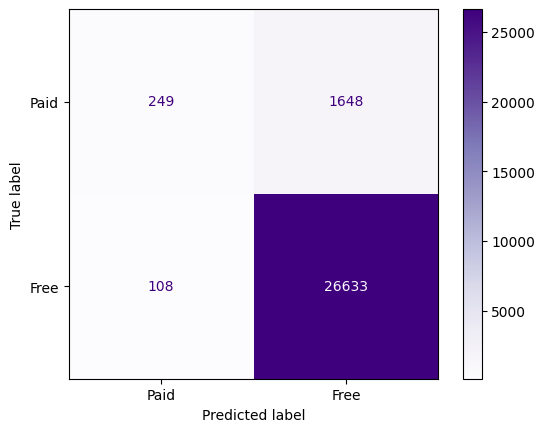

Precision score: 0.6974789915966386
Recall score: 0.1312598840274117
F1 score: 0.2209405501330967


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, predictions)
disp =ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Paid', 'Free']
)
disp.plot(cmap="Purples")
plt.savefig("./data_visualization/graphs/confusion_mat.jpg", format="jpg")
plt.show()

def precision(params):
    TP, FP = params['TP'], params['FP']
    return TP/(TP + FP)


def recall(params):
    TP, FN = params['TP'], params['FN']
    return TP/(TP + FN)


def f1_score(params):
    prec, rec = precision(params), recall(params)
    return (2*prec*rec)/(prec + rec)

print(f"Precision score: {precision(first_result)}")
print(f"Recall score: {recall(first_result)}")
print(f"F1 score: {f1_score(first_result)}")

**Metrics**
As seen after running the last cell, the model quality varies significantly depending on the metric used. It's important to choose a metric that aligns with the established criteria.

**Model Evaluation**
As mentioned earlier, I will use the F1 metric. A score of ~0.221 is a poor result, so I will work on optimizing the model to find the parameters that yield the highest score.

**Optimization**
Since I do not have an explicit formula for the quality function with respect to the model parameters, I will not use gradient-based methods. Instead, I am forced to employ exploratory methods to search for parameter values that will maximize the model quality.
I plan to use the Grid Search method, which will explore a grid of parameters to find the best set of solutions.
Simultaneously, I intend to run 6 scripts, each with a different gamma parameter, to search for solutions for 200 different values of the C parameter.

Optimization script is available at **optimizers/rbf_opt.py**


In [11]:
import re


def extract_score(line):
    pattern = "score: (\S+)"
    match = re.search(pattern, line)
    return float(match.group(1))


def extract_c(line):
    pattern = "C:(\S+)"
    match = re.search(pattern, line)
    return float(match.group(1)[:-1])


def extract_data_from_file(filename):
    with open(filename, "r") as file:
        C = []
        quality = []
        lines = file.readlines()
        for line in lines:
            stripped_line = line.rstrip()
            C.append(extract_c(stripped_line))
            if line[0] == 'f':
                quality.append(0)
            else:
                quality.append(extract_score(stripped_line))
    return C, quality

## Optimization Results
I created a search grid consisting of 6 different gamma parameters and 200 values for the C parameter.
The following plots show the relationship between the model quality and the value of the C parameter for the fixed gamma values.

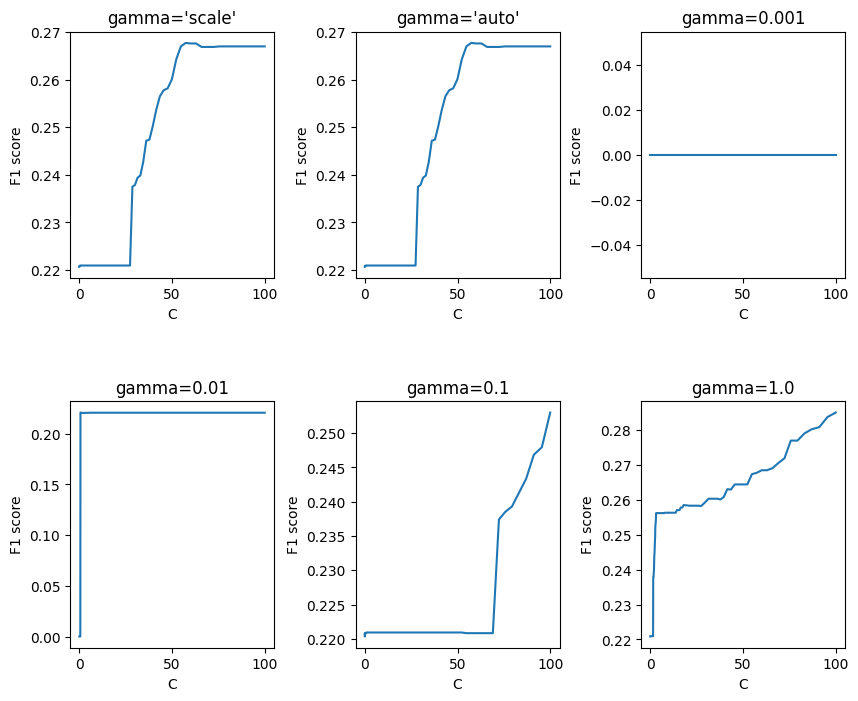

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
C, quality_scale = extract_data_from_file("./optimizers/data/rbf_scale.txt")
_, quality_auto = extract_data_from_file("./optimizers/data/rbf_auto.txt")
_, quality_0_001 = extract_data_from_file("./optimizers/data/rbf_0.001.txt")
_, quality_0_01 = extract_data_from_file("./optimizers/data/rbf_0.01.txt")
_, quality_0_1 = extract_data_from_file("./optimizers/data/rbf_0.1.txt")
_, quality_1_0 = extract_data_from_file("./optimizers/data/rbf_1.0.txt")
plt.subplots_adjust(wspace=0.4, hspace=0.5)
axes = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]

axes[0].plot(C, quality_scale)
axes[0].set_title("gamma='scale'")

axes[1].plot(C, quality_auto)
axes[1].set_title("gamma='auto'")

axes[2].plot(C, quality_0_001)
axes[2].set_title("gamma=0.001")

axes[3].plot(C, quality_0_01)
axes[3].set_title("gamma=0.01")

axes[4].plot(C, quality_0_1)
axes[4].set_title("gamma=0.1")

axes[5].plot(C, quality_1_0)
axes[5].set_title("gamma=1.0")

for a in axes:
    a.set_xlabel("C")
    a.set_ylabel("F1 score")


fig.savefig("./data_visualization/graphs/optimization_result.jpg", format="jpg")

The most promising gamma values, for which I can continue searching for better model quality, are gamma=0.1 and gamma=1.0.
Since the model is quite slow, I will choose one gamma value, namely gamma=1.0, and proceed with the optimization.

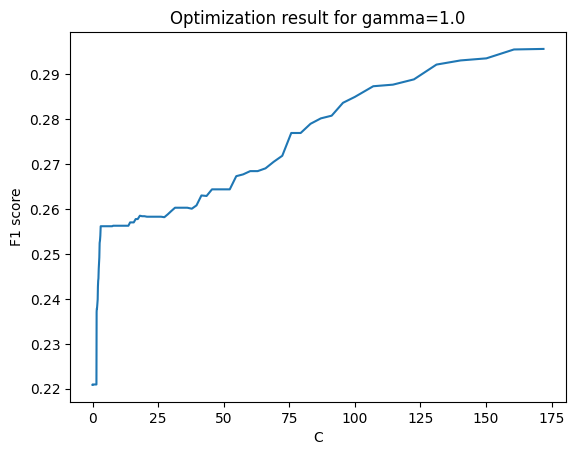

In [16]:
C, quality_1_0 = extract_data_from_file("./optimizers/data/final_data.txt")
plt.plot(C, quality_1_0)
plt.ylabel("F1 score")
plt.xlabel("C")
plt.title("Optimization result for gamma=1.0")
plt.savefig("./data_visualization/graphs/final_optimization.jpg", format='jpg')
plt.show()

## Final Optimization Result
The best result I managed to achieve is an F1 score of 0.295687885010267, with C = 171.90722018585745 and gamma = 1.0.
However, with these parameters, the model prediction time exceeds 1500 seconds!
The best result with a much shorter prediction time is F1 = 0.2921997523730912 for C = 131.11339374215643. I will focus on this model for further development.

In [13]:
final_model = model = SVC(kernel='rbf', C=131.11339374215643, gamma=1.0)
final_model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

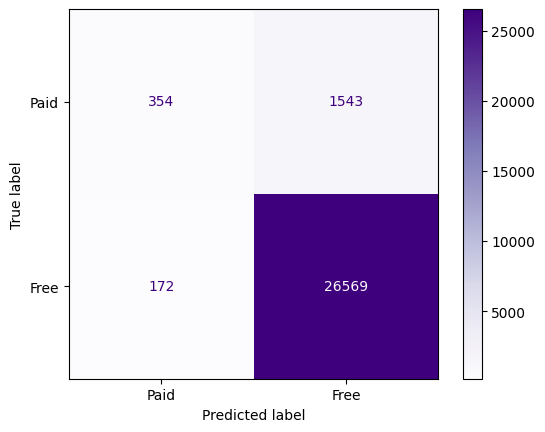

First result: {'TP': 249, 'TN': 26633, 'FP': 108, 'FN': 1648}
Final result: {'TP': 354, 'TN': 26569, 'FP': 172, 'FN': 1543}
First result:
Precision score: 0.6974789915966386
Recall score: 0.1312598840274117
F1 score: 0.2209405501330967
Final result:
Precision score: 0.6730038022813688
Recall score: 0.18661043753294676
F1 score: 0.2921997523730912


In [14]:


cm = confusion_matrix(Y_test, predictions)
disp =ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Paid', 'Free']
)
disp.plot(cmap="Purples")
plt.savefig("./data_visualization/graphs/final_confusion_mat.jpg", format="jpg")
plt.show()


final_result = provide_model_results(predictions, Y_test)

print(f"First result: {first_result}")
print(f"Final result: {final_result}")
print("First result:")
print(f"Precision score: {precision(first_result)}")
print(f"Recall score: {recall(first_result)}")
print(f"F1 score: {f1_score(first_result)}")
print("Final result:")
print(f"Precision score: {precision(final_result)}")
print(f"Recall score: {recall(final_result)}")
print(f"F1 score: {f1_score(final_result)}")

## Optimization Evaluation
As observed, the model improved its ability to correctly classify paid applications and reduced the number of misclassifications of free applications as paid ones.
Ultimately, the model optimization resulted in a 32.25% improvement in model quality.

## Conclusions and Reflections
Is an F1 score of 0.2921997523730912 good? No, it’s still a poor result.
Is a 32.25% improvement in model quality after 30 hours of optimization good? No, it’s not enough.
In my opinion, the main problem here is the choice of the model relative to the data size. A single iteration of optimization takes too long, and optimizing over a parameter grid with more than two dimensions could take months.
Moreover, there are no trivial dependencies between the parameters. Perhaps neural networks would perform better in this scenario.